<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/PytorchBasics/blob/main/15_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

#from google.colab import drive

In [14]:
from google.colab import drive

## Initialization

In [15]:
#device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
#Path
#Download the data from here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>_ and extract it to the current directory.
data_dir = '/content/drive/MyDrive/work/Adaptive Control Systems and AI Methods/hymenoptera_data'

In [17]:
mean = np.array([0.485,0.456,0.406])
std = np.array([0.229,0.224,0.255])

In [46]:
num_classes = 2
num_epoch = 24
batch_size = 4

lr = 0.0001

PATH = './cnn.pth'

# Create data sets and data loaders

In [47]:
data_transforms = {
    'train': transforms.Compose(
    [transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)]),
     'val': transforms.Compose(
         [transforms.Resize(256),
          transforms.RandomCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(mean, std)])
}

In [48]:
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),
                                         data_transforms[x])
                  for x in ['train', 'val']}

In [49]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=0)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)


['ants', 'bees']


In [50]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [51]:
inputs, classes = next(iter(dataloaders['train']))

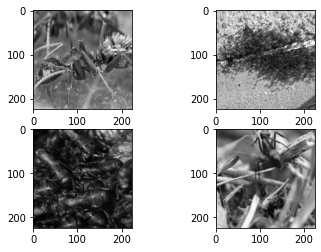

In [52]:
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(inputs[i][0], cmap = 'gray')

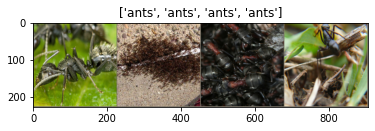

In [55]:
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs):
  since = time.time()
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range (num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' *10)

    #Each epoch has a training and validation phase
    for phase in ['train','val']:
      if phase == 'train':
         model.train()# set model to training mode
      else:
         model.eval() # set model evaluate mode
      
      running_loss = 0.0
      running_corrects = 0.0

      # Iterate over data
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        #forward
        #track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)




# Neural network architecture

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x


In [ ]:
model = ConvNet().to(device)

# Loss and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training

In [ ]:
n_total_steps = len(train_loader)

for epoch in range(num_epoch):
  for i, (images, labels) in enumerate(train_loader):
    #100, 1, 28, 28
    #100, 784 
    images = images.to(device)
    labels = labels.to(device)

    #forward
    outputs = model(images)
    loss = criterion(outputs, labels)

    #backwards
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i-1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{num_epoch}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')


Epoch [1/24], Step [2/12500], Loss: 0.7414
Epoch [1/24], Step [102/12500], Loss: 1.2628
Epoch [1/24], Step [202/12500], Loss: 0.2905
Epoch [1/24], Step [302/12500], Loss: 0.5834
Epoch [1/24], Step [402/12500], Loss: 0.2316
Epoch [1/24], Step [502/12500], Loss: 0.1421
Epoch [1/24], Step [602/12500], Loss: 0.4348
Epoch [1/24], Step [702/12500], Loss: 0.4682
Epoch [1/24], Step [802/12500], Loss: 0.8208
Epoch [1/24], Step [902/12500], Loss: 1.4647
Epoch [1/24], Step [1002/12500], Loss: 0.7195
Epoch [1/24], Step [1102/12500], Loss: 0.1564
Epoch [1/24], Step [1202/12500], Loss: 0.2400
Epoch [1/24], Step [1302/12500], Loss: 1.0250
Epoch [1/24], Step [1402/12500], Loss: 0.4663
Epoch [1/24], Step [1502/12500], Loss: 1.1078
Epoch [1/24], Step [1602/12500], Loss: 0.8274
Epoch [1/24], Step [1702/12500], Loss: 0.2818
Epoch [1/24], Step [1802/12500], Loss: 0.7492
Epoch [1/24], Step [1902/12500], Loss: 0.7928
Epoch [1/24], Step [2002/12500], Loss: 0.6183
Epoch [1/24], Step [2102/12500], Loss: 0.4936


KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), PATH)

# Test

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')



Accuracy of the network: 64.5 %
Accuracy of plane: 72.0 %
Accuracy of car: 73.1 %
Accuracy of bird: 55.3 %
Accuracy of cat: 58.5 %
Accuracy of deer: 54.9 %
Accuracy of dog: 42.1 %
Accuracy of frog: 72.0 %
Accuracy of horse: 66.5 %
Accuracy of ship: 78.5 %
Accuracy of truck: 72.1 %
